# Full Workflow

In [1]:
from funcs import *

In [2]:
RepoPath = '/home/shreejit/Dropbox/Academic/WORK/CBCMassesToGWSNR'
mass_min = 5.
mass_max = 445. # Heavier than this will lower the merger freq of heaviest BBH (225, 225) below f_min
templ_fmin = 10. # start freq of templates
i_f_start = 2**11 # = 2048. Starting INDEX for freq of the PSD
Mtot = np.arange(10, mass_min+mass_max, 10)
Data = {'Total Mass': Mtot, 'Sample Frequencies': [], 'PSD': {}, \
        'Redshift': {}, 'Max Horizon': {}}

## Finding Horizon

In [ ]:
first_time = True
for RUN in ["O1", "O2"]:
    Data['Redshift'][RUN] = []
    Data['Max Horizon'][RUN] = {}
    Data['PSD'][RUN] = {}
    for det in ['H1', 'L1']:
        # Read PSD
        path="{0}/CBCMassesToGWSNR/Data/PSDs/{1}/{2}_{1}_PSD.txt"\
        .format(WPATH, RUN, det)
        psd = np.genfromtxt(path, delimiter=" ")
        if first_time:
            Data['Sample Frequencies'] = psd[:, 0]
            first_time = False
        Data['PSD'][RUN][det] = psd[:, 1]
    
    for M in tqdm(Data['Total Mass']):
        # ATTN: Only L1 PSD used for calculating horizon redshift
        Data['Redshift'][RUN].append(horizon_redshift(Data['Sample Frequencies'][i_f_start:],\
                                                      Data['PSD'][RUN]['L1'][i_f_start:], \
                                                      omega=OMEGA, m1=M/2., m2=M/2.))
    Data['Redshift'][RUN] = np.array(Data['Redshift'][RUN])
    # catch max redshift, corresponding mass and luminosity distance
    i_max = Data['Redshift'][RUN].argmax()
    
    Data['Max Horizon'][RUN]['Total Mass'] = Data['Total Mass'][i_max]
    Data['Max Horizon'][RUN]['Redshift'] = Data['Redshift'][RUN][i_max]
    Data['Max Horizon'][RUN]['Luminosity Distance'] = \
    lal.LuminosityDistance(OMEGA, Data['Redshift'][RUN][i_max])

### Save/Load data

In [3]:
# np.save("{0}/CBCMassesToGWSNR/Data/Horizon_data.npy".format(WPATH), Data)
Data = np.load("{0}/CBCMassesToGWSNR/Data/Horizon_data.npy".format(WPATH)).item()

In [4]:
Zmax = {}
for RUN in ["O1", "O2"]:
    print "{}: Maximum Horizon Redshift is {} for a binary with total mass {}".\
    format(RUN, Data['Max Horizon'][RUN]['Redshift'],\
           Data['Max Horizon'][RUN]['Total Mass'])
    # Conservatively setting the max z 0.1 higher than obtained z
    Zmax[RUN] = Data['Max Horizon'][RUN]['Redshift'] + 0.1

O1: Maximum Horizon Redshift is 0.901595915594 for a binary with total mass 170.0
O2: Maximum Horizon Redshift is 1.23197057155 for a binary with total mass 160.0


# Plotting

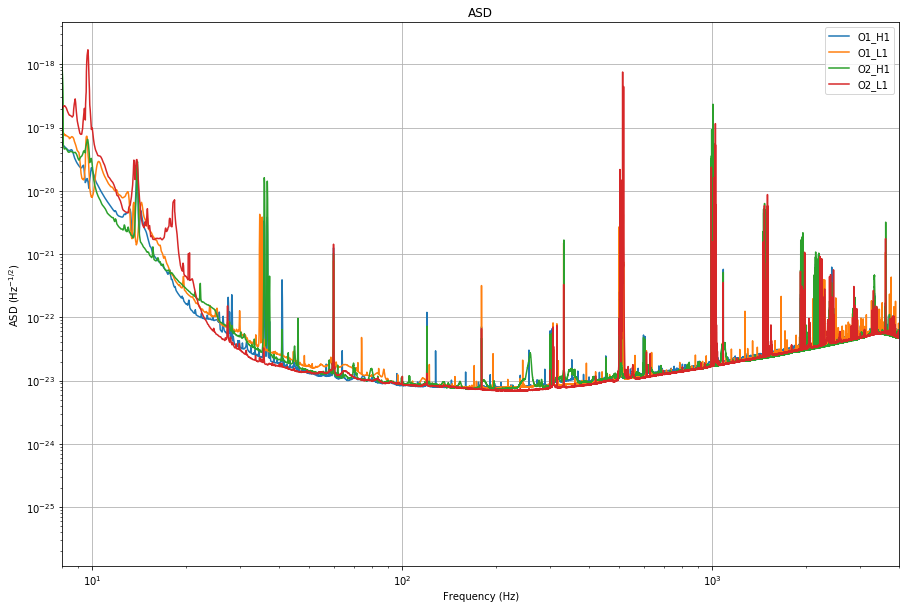

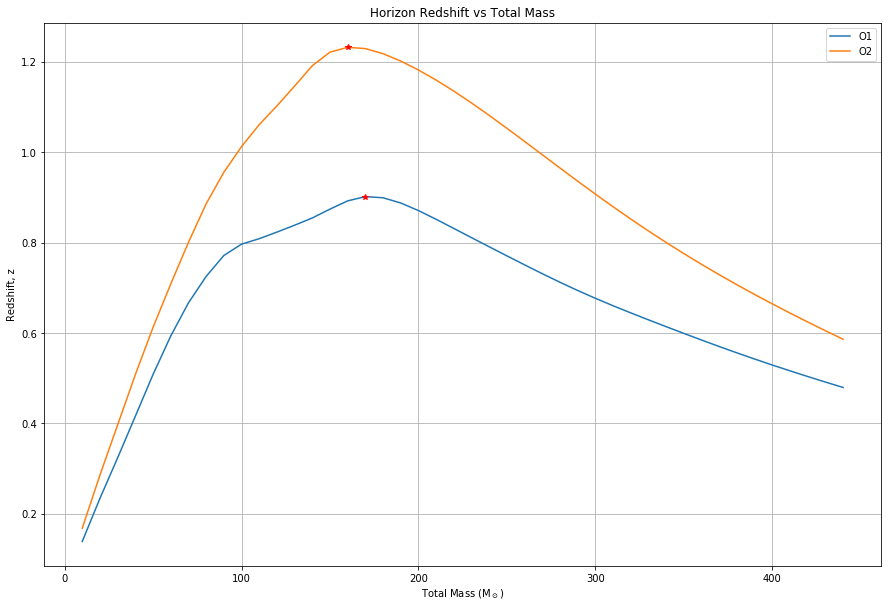

In [5]:
fig = plt.figure(figsize=(15,10))
fig2 = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax2 = fig2.add_subplot(111)

for RUN in ["O1", "O2"]:
    # Plot the PSD and z vs M
    for det in ['H1', 'L1']:
        ax1.loglog(Data['Sample Frequencies'], Data['PSD'][RUN][det]**0.5, \
                   label=RUN+'_'+det)
    ax2.plot(Data['Total Mass'], Data['Redshift'][RUN], label=RUN)
    ax2.plot([Data['Total Mass'][Data['Redshift'][RUN].argmax()]], \
             [Data['Redshift'][RUN][Data['Redshift'][RUN].argmax()]], 'r*')

ax1.set_title('ASD')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('ASD (Hz$^{-1/2}$)')
ax1.legend()
ax1.set_xlim(8., 4000.)
ax1.grid()

ax2.set_title('Horizon Redshift vs Total Mass')
ax2.set_xlabel('Total Mass (M$_\odot$)')
ax2.set_ylabel('Redshift, z')
ax2.legend()
ax2.grid()

plt.show()

# Injections

In [6]:
N = 100000 # Number of injections
df = Data['Sample Frequencies'][1] - Data['Sample Frequencies'][0]
Distributions = {"Uniform": Uniform, "Log_Flat": log_flat, "Power_Law": pow_law}

## Create HDF file

In [ ]:
DtTime = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-')[:-10]
Path = "{}/Data/{}_Injection_Data_{}.hdf5".format(RepoPath, DtTime, N)
# Create HDF5 file
inj_data = hp.File(Path, "a")
print("Data File: " + Path)

### Here we use random delta and iota; however LIGO R&P uses 
    delta = np.arcsin(np.random.uniform(-1.0, 1.0, Md))
    iota = np.arccos(np.random.uniform(-1.0, 1.0, Md))
This will influence results as we deal with thresholded data

## Random sky position, orientation, spins and polarization

In [ ]:
alpha, delta, iota, spin1, spin2, pol, inj_t = sample_params(N)
Iota = inj_data.create_dataset("iota", data=iota)
inj_data.create_dataset("alpha", data=alpha)
inj_data.create_dataset("delta", data=delta)
Spin1 = inj_data.create_dataset("spin1", data=spin1)
Spin2 = inj_data.create_dataset("spin2", data=spin2)
inj_data.create_dataset("polarization", data=pol)
inj_data.create_dataset("injection_time", data=gps_time)

## Evaluating SNRs

In [ ]:
for RUN in ['O1', 'O2']:
    # Draw redshift values such that the injections are uniform in comoving vol
    z = sample_redshifts(Zmax[RUN], N)
    # Convert to luminosity distances
    dlum = convert_to_dlum(z)
    # Find effective distances for corresponding detectors
    d_eff_dict = find_eff_d(dlum, alpha, delta, pol, iota, inj_t)
    
    inj_data_for_run = inj_data.create_group(RUN)

    psd_H1 = pf.FrequencySeries(Data['PSD'][RUN]['H1'], delta_f=df)
    psd_L1 = pf.FrequencySeries(Data['PSD'][RUN]['L1'], delta_f=df)

    # In each distribution
    for distrib in Distributions:
        in_distrib = inj_data_for_run.create_group(distrib)
        # Masses M1 and M2 generated according to "Distribution"
        m1, m2 = Distributions[distrib](N, mass_min, mass_max)
        Mass1 = in_distrib.create_dataset("Mass1", data=m1)
        Mass2 = in_distrib.create_dataset("Mass2", data=m2)
        # Calculating SNRs
        SNR = []
        for i in tqdm(range(N)):
            # print("mass1=", m1[i], " mass2=", m2[i], " z=", z[i], " spin1z=", spin1[i], \
            #      " spin2z=", spin2[i], " inclination=", iota[i])
            # Get each template
            sptilde, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m1[i]*(1+z[i]), mass2=m2[i]*(1+z[i]),\
                                         spin1z=spin1[i], spin2z=spin2[i], distance=1., inclination=iota[i],\
                                         delta_f=df, f_lower=templ_fmin, \
                                         f_final=Data['Sample Frequencies'][-1])
            sptilde.resize(len(Data['PSD']['O1']['L1']))
            rho = mf.sigmasq(sptilde, psd=psd_H1, \
                             low_frequency_cutoff=Data['Sample Frequencies'][0]) / (d_eff_dict['H1'][i] ** 2.)
            rho += mf.sigmasq(sptilde, psd=psd_L1, \
                              low_frequency_cutoff=Data['Sample Frequencies'][0]) / (d_eff_dict['L1'][i] ** 2.)
            rho **= 0.5
            SNR.append(rho)
        SNR = np.array(SNR)
        # Save the SNR array for the current distribution
        in_distrib.create_dataset("SNR", data=SNR)

In [ ]:
inj_data.close()

# Plotting Results

### Load HDF5 file and observed event data

In [7]:
DtTime = '2019-09-16_22-47'
Path = "{}/Data/{}_Injection_Data_{}.hdf5".format(RepoPath, DtTime, N)
inj_data = hp.File(Path, "r")
# Observed data
with open("{}/Data/observed_events.json".format(RepoPath), 'r') as f:
    Obs = json.load(f)
del Obs['data']['GW170817'] # Removing BNS event

## Define parameters

In [8]:
# no of bins
nbins = 10
# Runs: O1', 'O2'
SNR_max = 60.
# Annotation y coordinate placing
annot_y = 0.026     # Has to be adjusted manually
event_col = 'r'
# SNR Thresholds
Thresh_color = {8: 'b', 13: 'g', 18: 'm'}
# line width
lwid = 1
# fontsize
Fsiz = 13
# Save Figs
SaveFigs = True
# Fig size
FigSiz = (5,5)

In [9]:
alpha = inj_data['alpha']
delta = inj_data['delta']
Iota = inj_data['iota']
spin1 = inj_data['spin1']
spin2 = inj_data['spin2']
polarization = inj_data['polarization']

## Observable Distributions

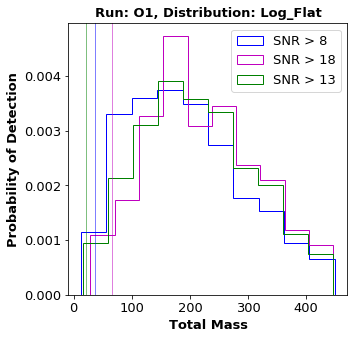

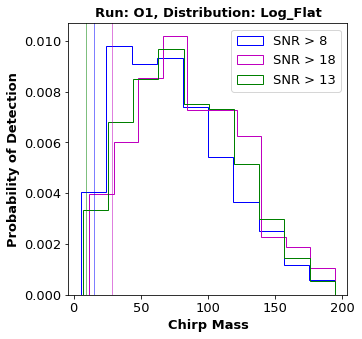

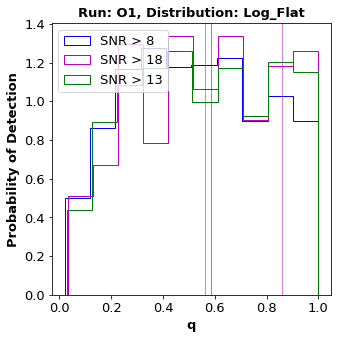

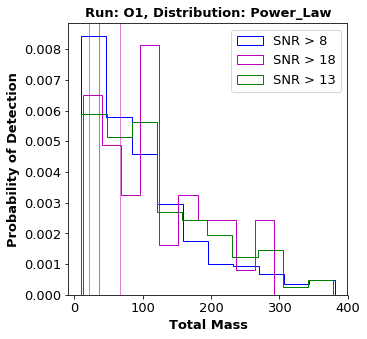

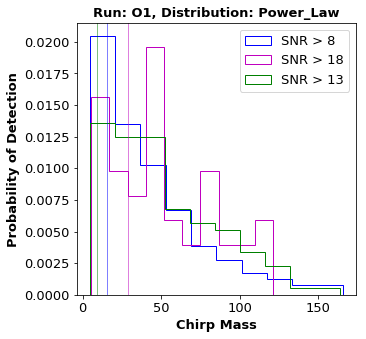

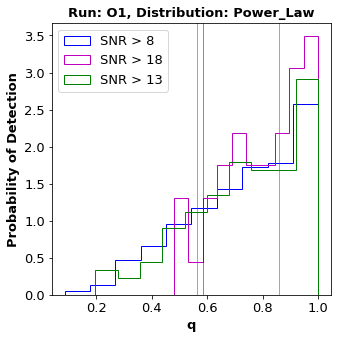

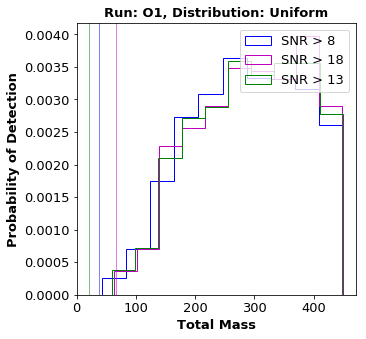

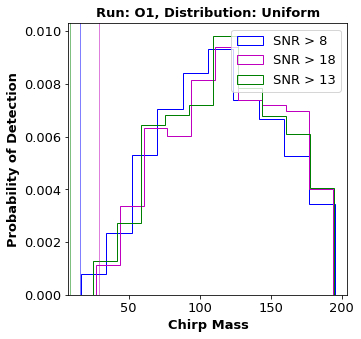

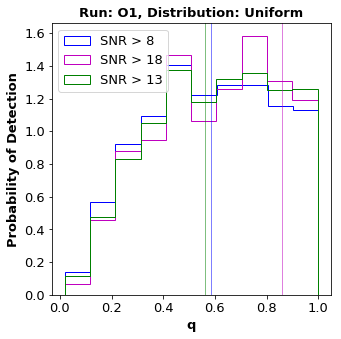

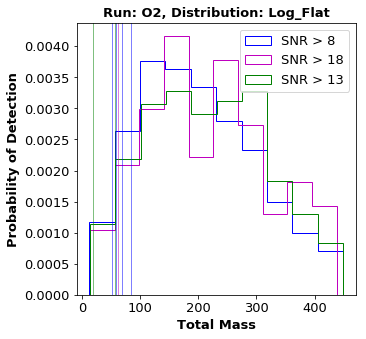

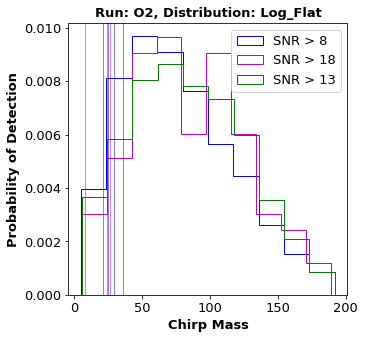

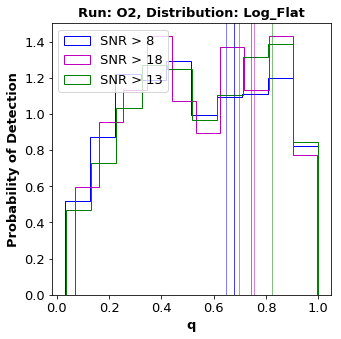

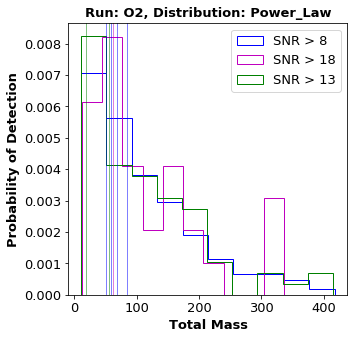

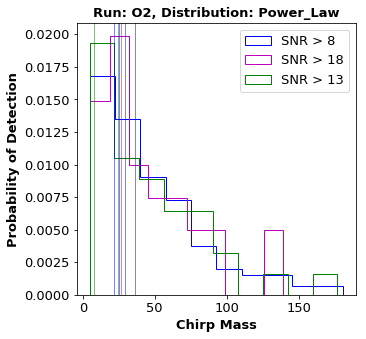

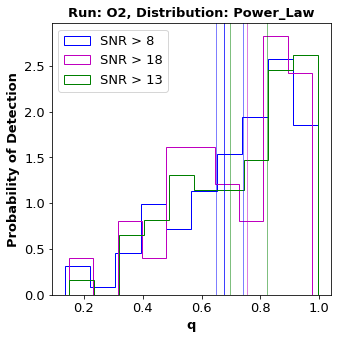

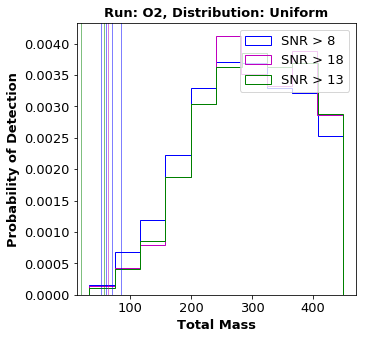

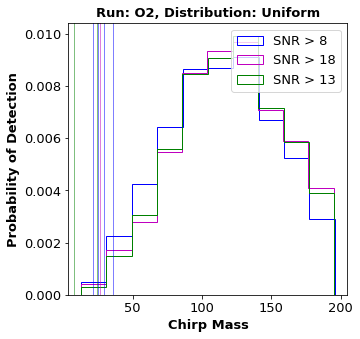

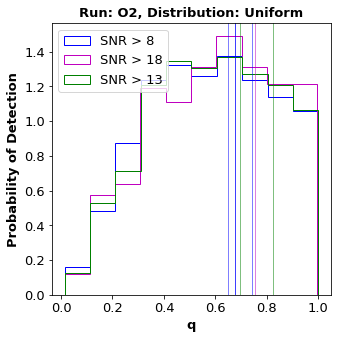

In [10]:
for RUN in ['O1', 'O2']:
    for distrib in Distributions:
        # Read data
        m1 = inj_data[RUN][distrib]['Mass1'].value
        m2 = inj_data[RUN][distrib]['Mass2'].value
        snrs = inj_data[RUN][distrib]['SNR'].value
        # Calculate values to be plotted
        # total mass
        M = (m1 + m2)
        # chirp mass
        mchirp = ChirpMass(m1, m2)
        # mass ratio
        q = m1 / m2
        q[q>1.] = 1/q[q>1.]
        # Plot Obs total mass
        plt.figure(figsize=FigSiz)
        Plot_Hist(M, RUN, snrs, SNR_max, Thresh_color, nbins, lwid)
        Plot_events(Obs, RUN, 'Total Mass', distrib, RepoPath, DtTime, mass_min, \
                    mass_max, N, Thresh_color, lwid, fsiz=Fsiz, Savefig=SaveFigs)
        plt.show()
        # Plot Obs chirp mass
        plt.figure(figsize=FigSiz)
        Plot_Hist(mchirp, RUN, snrs, SNR_max, Thresh_color, nbins, lwid)
        Plot_events(Obs, RUN, 'Chirp Mass', distrib, RepoPath, DtTime, mass_min, \
                    mass_max, N, Thresh_color, lwid, fsiz=Fsiz, Savefig=SaveFigs)
        plt.show()
        # Plot Obs mass ratio
        plt.figure(figsize=FigSiz)
        Plot_Hist(q, RUN, snrs, SNR_max, Thresh_color, nbins, lwid)
        Plot_events(Obs, RUN, 'q', distrib, RepoPath, DtTime, mass_min, \
                    mass_max, N, Thresh_color, lwid, fsiz=Fsiz, Savefig=SaveFigs)
        plt.show()